In [6]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

Generate synthetic lightcurve with count rate being r'=r+gamma\*sigma 

where sigma is flux error from original lc.*

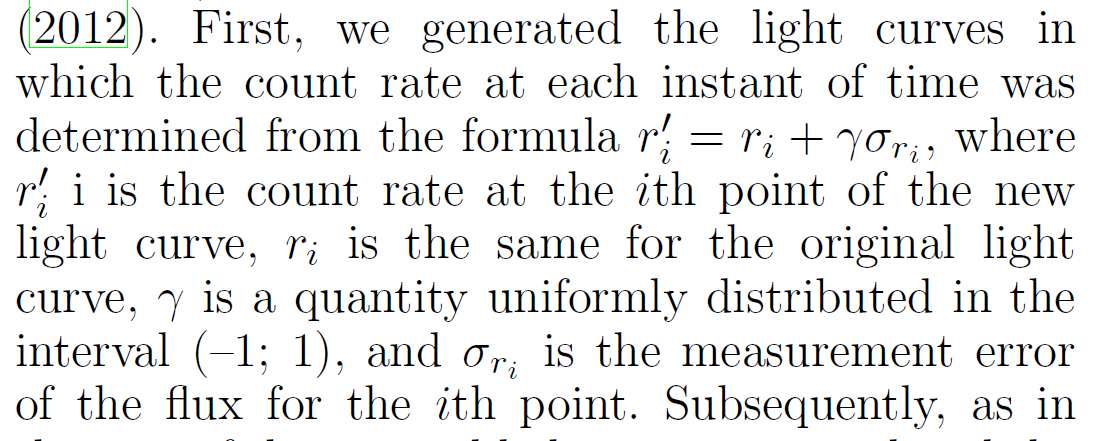

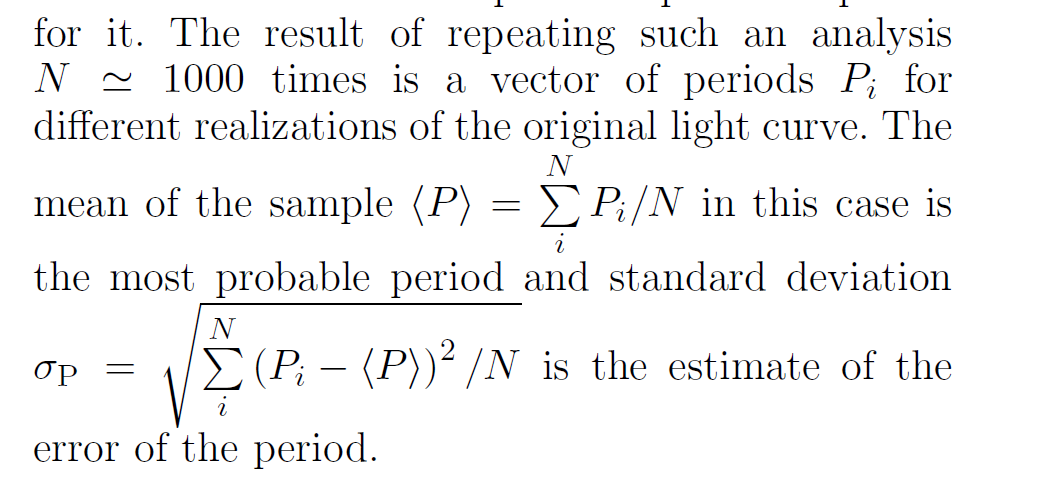



In [24]:
import os
import subprocess
import numpy as np
from astropy.io import fits

def generate_synthetic_light_curves(input_fits, output_folder, num_synthetic_curves):
    # Extract observation ID from the input file path (assumes folder name is observation ID)
    obs_id = input_fits.split('/')[1]

    # Create a specific output directory for the synthetic light curves and best_fit_period.txt
    output_dir = os.path.join(output_folder, obs_id)
    os.makedirs(output_dir, exist_ok=True)

    # Path for storing the best fit period file for the current obs_id
    best_fit_period_file = os.path.join(output_dir, 'best_fit_period.txt')

    # Open the input FITS file
    with fits.open(input_fits) as hdul:
        rate_data = hdul['RATE'].data
        time = rate_data['TIME']
        rate = rate_data['RATE']
        error = rate_data['ERROR']

        # Generate synthetic light curves and run efsearch
        for i in range(num_synthetic_curves):
            gamma = np.random.uniform(-1, 1, size=len(rate))
            synthetic_rate = rate + gamma * error

            # Create a new synthetic FITS file
            output_fits = os.path.join(output_dir, f'synthetic_light_curve_{i+11}.fits')

            hdul_new = hdul.copy()
            hdul_new['RATE'].data['RATE'] = synthetic_rate

            hdul_new.writeto(output_fits, overwrite=True)

            # Run efsearch on the synthetic light curve
            efsearch_cmd = f'efsearch {output_fits} window=- sepoch=INDEF dper=9.81 nphase=64 nbint=INDEF dres=0.0001 nper=1024 plot=no outfile=testing_efsearch.fes'
            try:
                subprocess.run(efsearch_cmd, shell=True, check=True)

                # Open the .fes FITS file and extract the best-fit period
                with fits.open('testing_efsearch.fes') as efsearch_fits:
                    results_data = efsearch_fits['RESULTS'].data
                    max_chisq_index = np.argmax(results_data['CHISQRD1'])
                    best_fit_period = results_data['PERIOD'][max_chisq_index]

                # Write the light curve name and best-fit period to the individual output file
                with open(best_fit_period_file, 'a') as f_out:
                    f_out.write(f"{output_fits}\t{best_fit_period}\n")
                print(f"Processed {output_fits}, Best-fit period: {best_fit_period}")

            except subprocess.CalledProcessError as e:
                print(f"Error processing {output_fits}: {e}")

            # Delete the synthetic FITS file to save space
            os.remove(output_fits)
            print(f"Deleted synthetic light curve {i+1} to save space.")

def read_light_curve_paths(base_dir):
    light_curve_paths = []

    for obs_id in os.listdir(base_dir):
        obs_dir = os.path.join(base_dir, obs_id)

        if os.path.isdir(obs_dir):  # Check if it's a directory
            input_fits_path = os.path.join(obs_dir, 'xti', 'event_cl', f'ni{obs_id}_cl_night_barycorrmpu7_sr_night.lc')

            if os.path.isfile(input_fits_path):  # Check if the light curve file exists
                light_curve_paths.append(input_fits_path)

    return light_curve_paths

In [26]:
if __name__ == "__main__":
    # Base directory containing observation ID folders
    base_dir = './'
    output_folder = './bootstrap_error/'

    # Number of synthetic light curves to generate
    num_synthetic_curves = 10

    # Read light curve paths
    light_curve_paths = read_light_curve_paths(base_dir)

    # Generate synthetic light curves for all light curve files found and run efsearch
    for path in light_curve_paths:
        generate_synthetic_light_curves(path, output_folder, num_synthetic_curves)

    print("Finished processing all light curves.")


 
efsearch 1.1 (xronos6.0)
 
 Series 1 file    1:./bootstrap_error/6050390261/synthetic_light_curve_1.fits
 
 Selected FITS extensions: 1 - RATE TABLE;
 
 Source ............ Swift_J0243.6+61    Start Time (d) .... 20174 01:46:48.284
 FITS Extension ....  1 - `RATE      `   Stop Time (d) ..... 20174 20:33:42.084
 No. of Rows .......      7909600        Bin Time (s) ......   0.2500E-03
 Right Ascension ... 40.9186             Internal time sys.. Converted to TJD
 Declination ....... 61.4323             Experiment ........ NICER    XTI
 
 Corrections applied: Vignetting - No ; Deadtime - No ; Bkgd - No ; Clock - Yes
 
 Selected Columns:  1- Time;  2- Y-axis;  3- Y-error;  4- Fractional exposure;
 
 File contains binned data.
 
 
 Expected Start ... 20174.07416995370  (days)       1:46:48:284  (h:m:s:ms)
 Expected Stop .... 20174.85673708333  (days)      20:33:42: 84  (h:m:s:ms)
 
 Default Epoch is:  20174.00000
Type INDEF to accept the default value
 Epoch format is days.
 Period format 

### comparing light curves to check

In [18]:
# def are_light_curves_different(rate1, rate2, tolerance=1e-6):
#     # Compute element-wise absolute difference
#     diff = np.abs(rate1 - rate2)
    
#     # Check if all differences are smaller than the tolerance
#     if np.all(diff < tolerance):
#         return False  # They are the same within the tolerance
#     else:
#         return True   # They are different
    
# with fits.open('./bootstrap_error/6050390261/synthetic_light_curve_1.fits') as hdul:
#         rate_data = hdul['RATE'].data
#         time = rate_data['TIME']
#         rate1 = rate_data['RATE']
#         error1 = rate_data['ERROR']
# with fits.open('./bootstrap_error/6050390261/synthetic_light_curve_2.fits') as hdul:
#         rate_data = hdul['RATE'].data
#         time = rate_data['TIME']
#         rate2 = rate_data['RATE']
#         error2 = rate_data['ERROR']

# if are_light_curves_different(rate1, rate2):
#     print("The two light curves are different.")
# else:
#     print("The two light curves are identical or nearly identical.")